In [1]:
import argparse
import json
import os
import time
import ast
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

from src.dataset import IntendedReceiverDataset
from src.my_model import DualTransformer
from src.utils import calc_class_acc, get_params_str, num_trainable_params

In [17]:
import os, sys
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

from src.visualization import plot_action

In [2]:
params = {
    "model": 'transformer',
    "batch_size": 1,
    "n_features": 6,
    "n_classes": 11,
    "context_dim": 32,
    "trans_dim": 256,
    "add_info" : True
    
}

default_device = "cuda:0"
#model = nn.DataParallel(Model(params).to(default_device))
model = nn.DataParallel(DualTransformer(params).to(default_device))
save_path = "saved/{:03d}".format(51)
state_dict = torch.load("{}/model/{}_state_dict_best.pt".format(save_path, params['model']))
model.module.load_state_dict(state_dict)
model = model.eval()

/home/toc3/anaconda3/envs/py3_11/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [3]:
lst = []
for keys in state_dict.keys():
    lst.append(keys.split(".")[0])


from collections import Counter

Counter(lst)

Counter({'player_temporal_encoder': 24,
         'player_spatial_encoder': 24,
         'dist_temporal_encoder': 24,
         'dist_spatial_encoder': 24,
         'angle_temporal_encoder': 24,
         'angle_spatial_encoder': 24,
         'player_input_fc': 2,
         'dist_input_fc': 2,
         'angle_input_fc': 2,
         'output_fc': 2,
         'time_pos_encoder': 1,
         'player_pos_encoder': 1})

In [4]:
print("Generating datasets...")

dataset = pd.read_csv(f'./{save_path}/success_test_dataset.csv')
dataset['freeze_frame'] = dataset['freeze_frame'].apply(ast.literal_eval)
dataset['Baseline Intended-Receiver'] = dataset['Baseline Intended-Receiver'].apply(ast.literal_eval)
dataset.sort_values(by='game_id')
print(dataset.shape)
dataset.head()

Generating datasets...
(289, 25)


,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,...,goal,ownGoal,teamId,eventName,freeze_frame,accurate,value_label,Baseline Intended-Receiver,game_id,event_id
0,Home,PASS,PASS,2,130403,5216.12,130443,5217.72,A11,A14,...,0,0,1,Pass,"{'A02': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'A14', 'end_x': 19.12680000000...",1,1602
1,Home,PASS,PASS,2,106766,4270.64,106785,4271.40,A12,A13,...,0,0,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'A13', 'end_x': 29.25612, 'end...",2,3346
2,Home,PASS,PASS,1,44871,1794.84,44898,1795.92,A10,A08,...,0,0,1,Pass,"{'A01': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'A08', 'end_x': 65.83896, 'end...",2,2407
3,Home,PASS,PASS,1,33376,1335.04,33427,1337.08,A04,A07,...,0,0,1,Pass,"{'A01': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'A07', 'end_x': 66.42323999999...",2,2257
4,Home,PASS,PASS,2,92194,3687.76,92229,3689.16,A02,A01,...,0,0,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'A01', 'end_x': 41.229, 'end_y...",2,3113


In [5]:
nw = len(model.device_ids) * 4
test_dataset = IntendedReceiverDataset(dataset)
print(len(test_dataset))
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=nw, pin_memory=True)
test_loader

285


In [12]:
losses = []

target_labels = []
predicted_labels = []
predicted_prob = []

for batch_idx, data in tqdm(enumerate(test_loader)):
    passer_input = data[0].to(default_device)
    teammate_input = data[1].to(default_device)
    opponent_input = data[2].to(default_device)
    ball_input = data[3].to(default_device)

    team_poss_input = data[4].to(default_device)
    event_player_input = data[5].to(default_device)

    input = [
        passer_input,
        teammate_input,
        opponent_input,
        ball_input,
        team_poss_input,
        event_player_input,
    ]
    
    passer_mask_list = data[6].to(default_device)
    target = data[7].to(default_device)

    with torch.no_grad():
        out = model(*input)
        
    batch_size, _ = out.shape
    # 모든 값이 0인 mask 생성
    mask = torch.zeros_like(out)
    batch_indices = np.arange(batch_size)
    mask[batch_indices, passer_mask_list] = -np.inf
    out += mask 

    loss = nn.CrossEntropyLoss()(out, target)

    out = torch.softmax(out,dim=1)
    pred = torch.argmax(out).item()

    losses.append(loss.item())
    target_labels.append(target.item())
    predicted_labels.append(pred)  

    #각 선수들의 의도확률도 추출
    predicted_prob.append(out)

best_accuracy = (np.array(target_labels) == np.array(predicted_labels)).mean()

print("loss : ", np.mean(losses))
print("accuracy : ", best_accuracy)

285it [00:03, 78.08it/s]

loss :  0.19052917597824195
accuracy :  0.9368421052631579


285it [00:09, 30.04it/s]0:00<?, ?it/s]
285it [00:12, 23.03it/s]0:09<05:35,  9.87s/it]
285it [00:11, 23.85it/s]0:22<06:21, 11.57s/it]
285it [00:11, 24.27it/s]0:34<06:21, 11.93s/it]
285it [00:11, 24.12it/s]0:47<06:12, 12.01s/it]
285it [00:11, 24.43it/s]0:59<06:02, 12.09s/it]
285it [00:12, 23.43it/s]1:11<05:51, 12.10s/it]
285it [00:11, 24.06it/s]1:24<05:43, 12.27s/it]
285it [00:11, 23.81it/s]1:36<05:31, 12.28s/it]
285it [00:12, 23.70it/s]1:48<05:19, 12.27s/it]
285it [00:11, 25.18it/s]02:01<05:08, 12.33s/it]
285it [00:12, 22.76it/s]02:12<04:51, 12.14s/it]
285it [00:12, 23.66it/s]02:25<04:44, 12.39s/it]
285it [00:12, 23.58it/s]02:38<04:33, 12.41s/it]
285it [00:11, 24.23it/s]02:50<04:20, 12.41s/it]
285it [00:11, 25.16it/s]03:02<04:06, 12.34s/it]
285it [00:12, 22.78it/s]03:14<03:51, 12.16s/it]
285it [00:12, 23.60it/s]03:27<03:43, 12.39s/it]
285it [00:12, 23.10it/s]03:39<03:31, 12.42s/it]
285it [00:11, 23.93it/s]03:52<03:20, 12.54s/it]
285it [00:11, 25.09it/s]04:05<03:07, 12.49s/it]
285it [00:

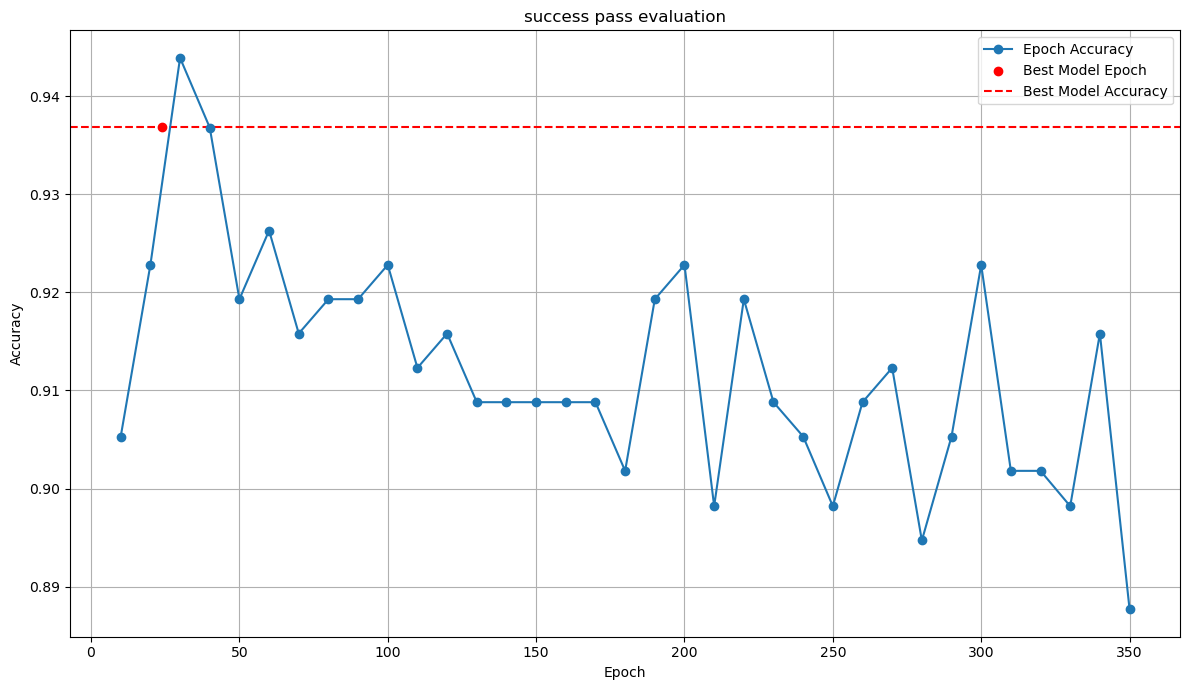

In [28]:
accuracy_lst = []
def test_model(pt, model, test_loader, default_device):
    losses = []

    target_labels = []
    predicted_labels = []

    for _, data in tqdm(enumerate(test_loader)):
        passer_input = data[0].to(default_device)
        teammate_input = data[1].to(default_device)
        opponent_input = data[2].to(default_device)
        ball_input = data[3].to(default_device)

        team_poss_input = data[4].to(default_device)
        event_player_input = data[5].to(default_device)

        input = [
            passer_input,
            teammate_input,
            opponent_input,
            ball_input,
            team_poss_input,
            event_player_input,
        ]

        passer_mask_list = data[6].to(default_device)
        target = data[7].to(default_device)

        with torch.no_grad():
            out = model(*input)
            
        batch_size, _ = out.shape
        # 모든 값이 0인 mask 생성
        mask = torch.zeros_like(out)
        batch_indices = np.arange(batch_size)
        mask[batch_indices, passer_mask_list] = -np.inf
        out += mask 

        loss = nn.CrossEntropyLoss()(out, target)

        out = torch.softmax(out,dim=1)
        pred = torch.argmax(out).item()

        losses.append(loss)
        target_labels.append(target.item())
        predicted_labels.append(pred)  

    accuracy = (np.array(target_labels) == np.array(predicted_labels)).mean()
    accuracy_lst.append(accuracy.round(4))

max_pt = 350
for pt in tqdm(range(10, max_pt+1, 10)):
    state_dict = torch.load("{}/model/{}_state_dict_{}.pt".format(save_path, params['model'], pt))
    model.module.load_state_dict(state_dict)
    model = model.eval()

    test_model(pt, model, test_loader, default_device)

plt.figure(figsize=(12, 7))

x_coords = list(range(10, max_pt+1, 10))
x_ticks = [str(epoch) if epoch % 50 == 0 or epoch == max_pt else '' for epoch in range(10, max_pt+1, 10)]

plt.plot(x_coords, accuracy_lst, label='Epoch Accuracy', marker='o', zorder=3)

plt.scatter(24, best_accuracy, color='red', label='Best Model Epoch', zorder=5)
plt.axhline(y=best_accuracy, color='red', linestyle='--', label='Best Model Accuracy', zorder=2)
# Best Model 점 표시

plt.title('success pass evaluation')
plt.xlabel('Epoch')
#plt.xticks(x_coords, x_ticks, rotation=45)  # 'best' 라벨 제외
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
print("error index : ", len(test_dataset.except_index))

correct_test_dataset = dataset[~dataset['event_id'].isin(test_dataset.except_index)]

print(correct_test_dataset.shape)

correct_test_dataset.head()

error index :  4
(285, 25)


,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,...,goal,ownGoal,teamId,eventName,freeze_frame,accurate,value_label,Baseline Intended-Receiver,game_id,event_id
0,Home,PASS,PASS,2,130403,5216.12,130443,5217.72,A11,A14,...,0,0,1,Pass,"{'A02': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'A14', 'end_x': 19.12680000000...",1,1602
1,Home,PASS,PASS,2,106766,4270.64,106785,4271.40,A12,A13,...,0,0,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'A13', 'end_x': 29.25612, 'end...",2,3346
2,Home,PASS,PASS,1,44871,1794.84,44898,1795.92,A10,A08,...,0,0,1,Pass,"{'A01': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'A08', 'end_x': 65.83896, 'end...",2,2407
3,Home,PASS,PASS,1,33376,1335.04,33427,1337.08,A04,A07,...,0,0,1,Pass,"{'A01': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'A07', 'end_x': 66.42323999999...",2,2257
4,Home,PASS,PASS,2,92194,3687.76,92229,3689.16,A02,A01,...,0,0,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",1.0,0,"{'dist': {'ID': 'A01', 'end_x': 41.229, 'end_y...",2,3113


In [14]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
correct_test_dataset['type_true'] = np.nan
correct_test_dataset['type_pred'] = np.nan

game_ids = correct_test_dataset['game_id'].unique()

traces_dict = {}
for game_id in game_ids:
    traces = pd.read_csv(f'../data/preprocess-data/tracking-data/match{game_id}.csv')
    traces.set_index('frame',inplace=True)
    traces_dict[game_id] = traces

In [20]:
from src.labels import get_nearest_receiver

correct_test_dataset = get_nearest_receiver(correct_test_dataset, traces_dict)

# 각 방식에 대한 정확도 계산
methods = ['dist_nearest', 'angle_nearest', 'dist and angle']

# 정확도를 계산하는 함수
def calculate_accuracy(events, method, label="to"):
    correct_predictions = events.apply(lambda row: row['Intended_Receiver'][method]['ID'] == row[label], axis=1)
    accuracy = correct_predictions.mean()
    return accuracy

accuracy = {method: calculate_accuracy(correct_test_dataset, method) for method in methods}
accuracy

{'dist_nearest': 0.2982456140350877,
 'angle_nearest': 0.7473684210526316,
 'dist and angle': 0.8105263157894737}

In [21]:
correct_test_dataset["True Intended-receiver"] = np.nan
correct_test_dataset["Pred Intended-receiver"] = np.nan
correct_test_dataset["Pred Intended-prob"] = {}

for i,(idx, row) in tqdm(enumerate(correct_test_dataset.iterrows())):
    game_id = row['game_id']
    traces = traces_dict[game_id]

    start_frame = row['start_frame']
    session = traces.at[start_frame,'session']
    frame_traces = traces.loc[start_frame-60 + 1 : start_frame+20]
    frame_traces = frame_traces[frame_traces['session'] == session]

    passer = row['from']
    team = passer[0]
    receiver = row['to']

    player_cols = [f"{c[:3]}{t}" for c in frame_traces.dropna(axis=1).columns if c.endswith("_speed") for t in test_dataset.feature_types]
    player_cols = sorted(player_cols, key=lambda c: (c[:3], test_dataset.feature_types.index(c[3:])))

    player_names = [c[:3] for c in player_cols if c.endswith("_x") and c[0] == team]
    label_dict = {idx:col for idx, col in enumerate(player_names)}   
    
    correct_test_dataset.at[idx,'True Intended-receiver'] = label_dict[target_labels[i]]
    correct_test_dataset.at[idx,'Pred Intended-receiver'] = label_dict[predicted_labels[i]]
    
    intended_prob = predicted_prob[i].squeeze()
    player_intended_prob = {label_dict[i] : float(intended_prob[i]) for i in range(len(intended_prob))} 
    correct_test_dataset.at[idx,'Pred Intended-prob'] = player_intended_prob

285it [00:00, 740.03it/s]


### 모델의 입출력에 문제가 있는지 검증

1. type_true가 to과 다른 경우
2. type_pred(intended-receiver)를 opponent로 예측한 경우
3. type_pred를 passer로 예측한 경우

In [22]:
correct_test_dataset[correct_test_dataset['to'] != correct_test_dataset['True Intended-receiver']]

,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,...,value_label,Baseline Intended-Receiver,game_id,event_id,type_true,type_pred,True Intended-receiver,Pred Intended-receiver,Pred Intended-prob,Intended_Receiver


In [23]:
correct_test_dataset[correct_test_dataset.apply(lambda row: row['to'][0] != row['Pred Intended-receiver'][0], axis=1)]

,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,...,value_label,Baseline Intended-Receiver,game_id,event_id,type_true,type_pred,True Intended-receiver,Pred Intended-receiver,Pred Intended-prob,Intended_Receiver


In [24]:
print(correct_test_dataset.shape)
print(correct_test_dataset[correct_test_dataset.apply(lambda row: row['from'] == row['Pred Intended-receiver'], axis=1)].shape)
correct_test_dataset[correct_test_dataset.apply(lambda row: row['from'] == row['Pred Intended-receiver'], axis=1)]

(285, 31)
(0, 31)


,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,...,value_label,Baseline Intended-Receiver,game_id,event_id,type_true,type_pred,True Intended-receiver,Pred Intended-receiver,Pred Intended-prob,Intended_Receiver


In [25]:
correct_test_dataset[correct_test_dataset['True Intended-receiver'] != correct_test_dataset['Pred Intended-receiver']].head()

,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,...,value_label,Baseline Intended-Receiver,game_id,event_id,type_true,type_pred,True Intended-receiver,Pred Intended-receiver,Pred Intended-prob,Intended_Receiver
23,Away,PASS,PASS,2,131246,5249.84,131300,5252.00,A06,A16,...,0,"{'dist': {'ID': 'A16', 'end_x': 38.16612000000...",3,6991,NaN,NaN,A16,A07,"{'A01': 0.00020231585949659348, 'A04': 0.02206...","{'dist_nearest': {'ID': 'A15', 'end_x': 70.589..."
32,Away,PASS,HEAD-INTERCEPTION-CLEARANCE,2,82542,3301.68,82594,3303.76,B21,B22,...,0,"{'dist': {'ID': 'B22', 'end_x': 97.3296, 'end_...",2,2977,NaN,NaN,B22,B18,"{'B15': 2.3095763026503846e-05, 'B16': 0.00885...","{'dist_nearest': {'ID': 'B16', 'end_x': 105.55..."
74,Away,PASS,PASS,1,5041,201.64,5102,204.08,B23,B18,...,0,"{'dist': {'ID': 'B18', 'end_x': 66.61547999999...",2,1832,NaN,NaN,B18,B17,"{'B15': 5.793563832412474e-05, 'B16': 0.001472...","{'dist_nearest': {'ID': 'B22', 'end_x': 59.530..."
92,Away,PASS,PASS,1,7196,287.84,7261,290.44,A06,A11,...,0,"{'dist': {'ID': 'A11', 'end_x': 100.84932, 'en...",3,3836,NaN,NaN,A11,A03,"{'A01': 1.8507249706090079e-06, 'A02': 0.00034...","{'dist_nearest': {'ID': 'A08', 'end_x': 78.314..."
97,Home,PASS,PASS,2,86103,3444.12,86156,3446.24,B25,B22,...,0,"{'dist': {'ID': 'B22', 'end_x': 60.74892, 'end...",3,5917,NaN,NaN,B22,B27,"{'B18': 7.62783529353328e-05, 'B20': 3.7266308...","{'dist_nearest': {'ID': 'B23', 'end_x': 63.589..."


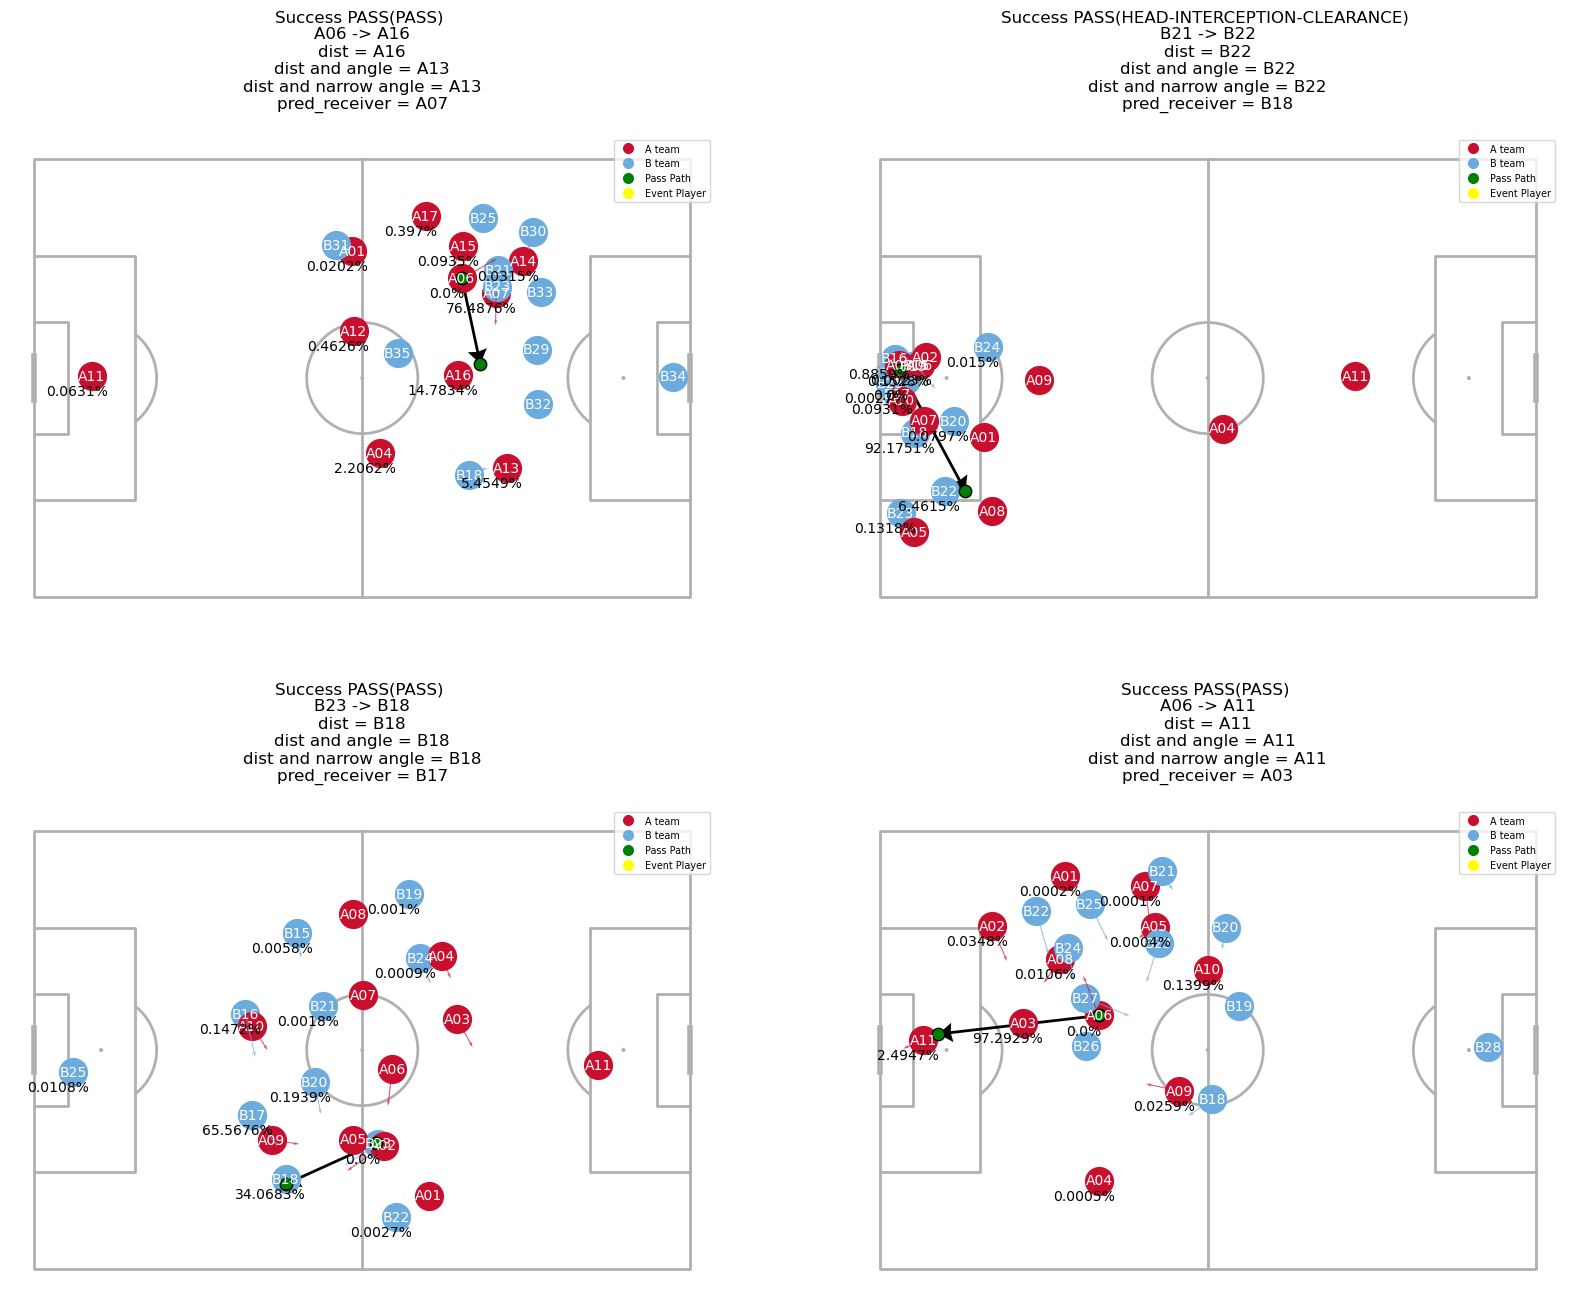

In [28]:
event_ids = [6991, 2977, 1832, 3836]

fig, ax = plt.subplots(2,2,figsize=(20,16))

ax_id = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]] 

for i, event_id in enumerate(event_ids):
    index = correct_test_dataset[correct_test_dataset['event_id'] == event_id].index[0]
    record = correct_test_dataset.loc[index]
    plot_action(record, ax=ax_id[i],field_dimen=(108,72),intended_prob_dict=record["Pred Intended-prob"])

plt.show()

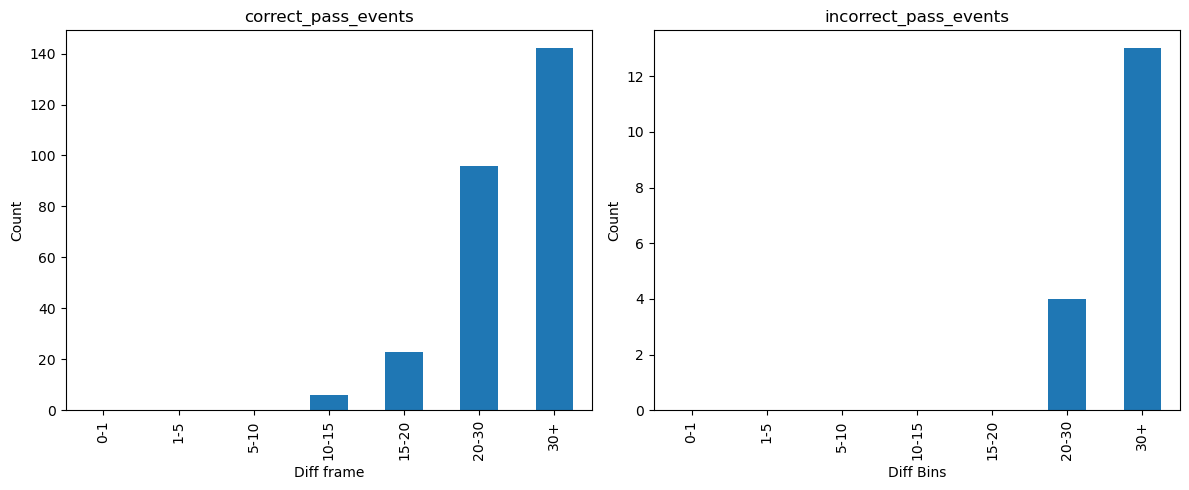

In [29]:
# 가정: 두 데이터프레임이 pass_events1과 pass_events2로 주어져 있다고 가정합니다.
# 이 예제 코드는 두 데이터프레임에 대해 동일한 처리를 적용한 후 결과를 양 옆으로 나란히 표시하는 방법을 보여줍니다.

correct_pass_events = correct_test_dataset[correct_test_dataset['True Intended-receiver'] == correct_test_dataset['Pred Intended-receiver']]
incorrect_pass_events = correct_test_dataset[correct_test_dataset['True Intended-receiver'] != correct_test_dataset['Pred Intended-receiver']]
# frame_diff 계산
correct_pass_events['frame_diff'] = correct_pass_events['end_frame'] - correct_pass_events['start_frame']
incorrect_pass_events['frame_diff'] = incorrect_pass_events['end_frame'] - incorrect_pass_events['start_frame']

# bins 설정
bins = [0, 1, 5, 10, 15, 20, 30, max(correct_pass_events['frame_diff'].max(), incorrect_pass_events['frame_diff'].max())]

# diff 데이터를 bins에 따라 분류
correct_pass_events['binned_diff'] = pd.cut(correct_pass_events['frame_diff'], bins=bins, right=False, labels=["0-1", "1-5","5-10", "10-15","15-20", "20-30", "30+"])
incorrect_pass_events['binned_diff'] = pd.cut(incorrect_pass_events['frame_diff'], bins=bins, right=False, labels=["0-1", "1-5","5-10", "10-15","15-20", "20-30", "30+"])

# 플롯 준비
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# 첫 번째 데이터프레임의 히스토그램
correct_pass_events['binned_diff'].value_counts().sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title('correct_pass_events')
axes[0].set_xlabel('Diff frame')
axes[0].set_ylabel('Count')

# 두 번째 데이터프레임의 히스토그램
incorrect_pass_events['binned_diff'].value_counts().sort_index().plot(kind='bar', ax=axes[1])
axes[1].set_title('incorrect_pass_events')
axes[1].set_xlabel('Diff Bins')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()
